The generated cluster set is [[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17, 18], [19, 20, 21, 22, 23], [24, 25, 26, 27], [28, 29, 30, 31, 32, 33, 34], [35, 36, 37, 38, 39]]
With [[6, 4], [3, 1], [2, 5, 0]] servers and server_targets have been configured


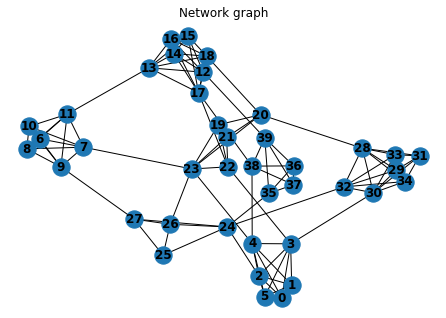

In [12]:
import os
import numpy as np
import pandas as pd
from data_dist import *
from data_utils import *
from utils import dataset_approve, save_file, model_size
from env_sysmodel import system_model, FL_Modes

dataset = 'mnist'
in_ch = 1
location, num_labels = dataset_approve(dataset)
traindata, testdata = dataset_select(dataset, location, in_ch) 
envnment  = system_model(40, 7, 3, prob_int = 0.95, prob_ext = 0.02)

In [13]:
def noniid(data, num_labels, num_users, alpha):
    dist = np.random.dirichlet([alpha] * num_users, num_labels)
    class_ids = [np.argwhere(data.targets==y).flatten() for y in range(num_labels)]
    device_dist  =[[] for _ in range(num_users)]
    users_dict = {i:None for i in range(num_users)}
    
    for c, fracs in zip(class_ids, dist):
        for i, ids in  enumerate(np.split(c, (np.cumsum(fracs)[:-1]*len(c)).astype(int))):
            device_dist[i] += [ids]
    ### New
#     for node in users_dict.keys():
#         users_dict[node] = [np.concatenate(ids) for ids in device_dist[node]]
#     return users_dict
        
    device_dist = [list(np.concatenate(ids)) for ids in device_dist]
    for node in users_dict.keys():
        np.random.shuffle(device_dist[node])
        users_dict[node] = device_dist[node]
    return users_dict
#     return device_dist

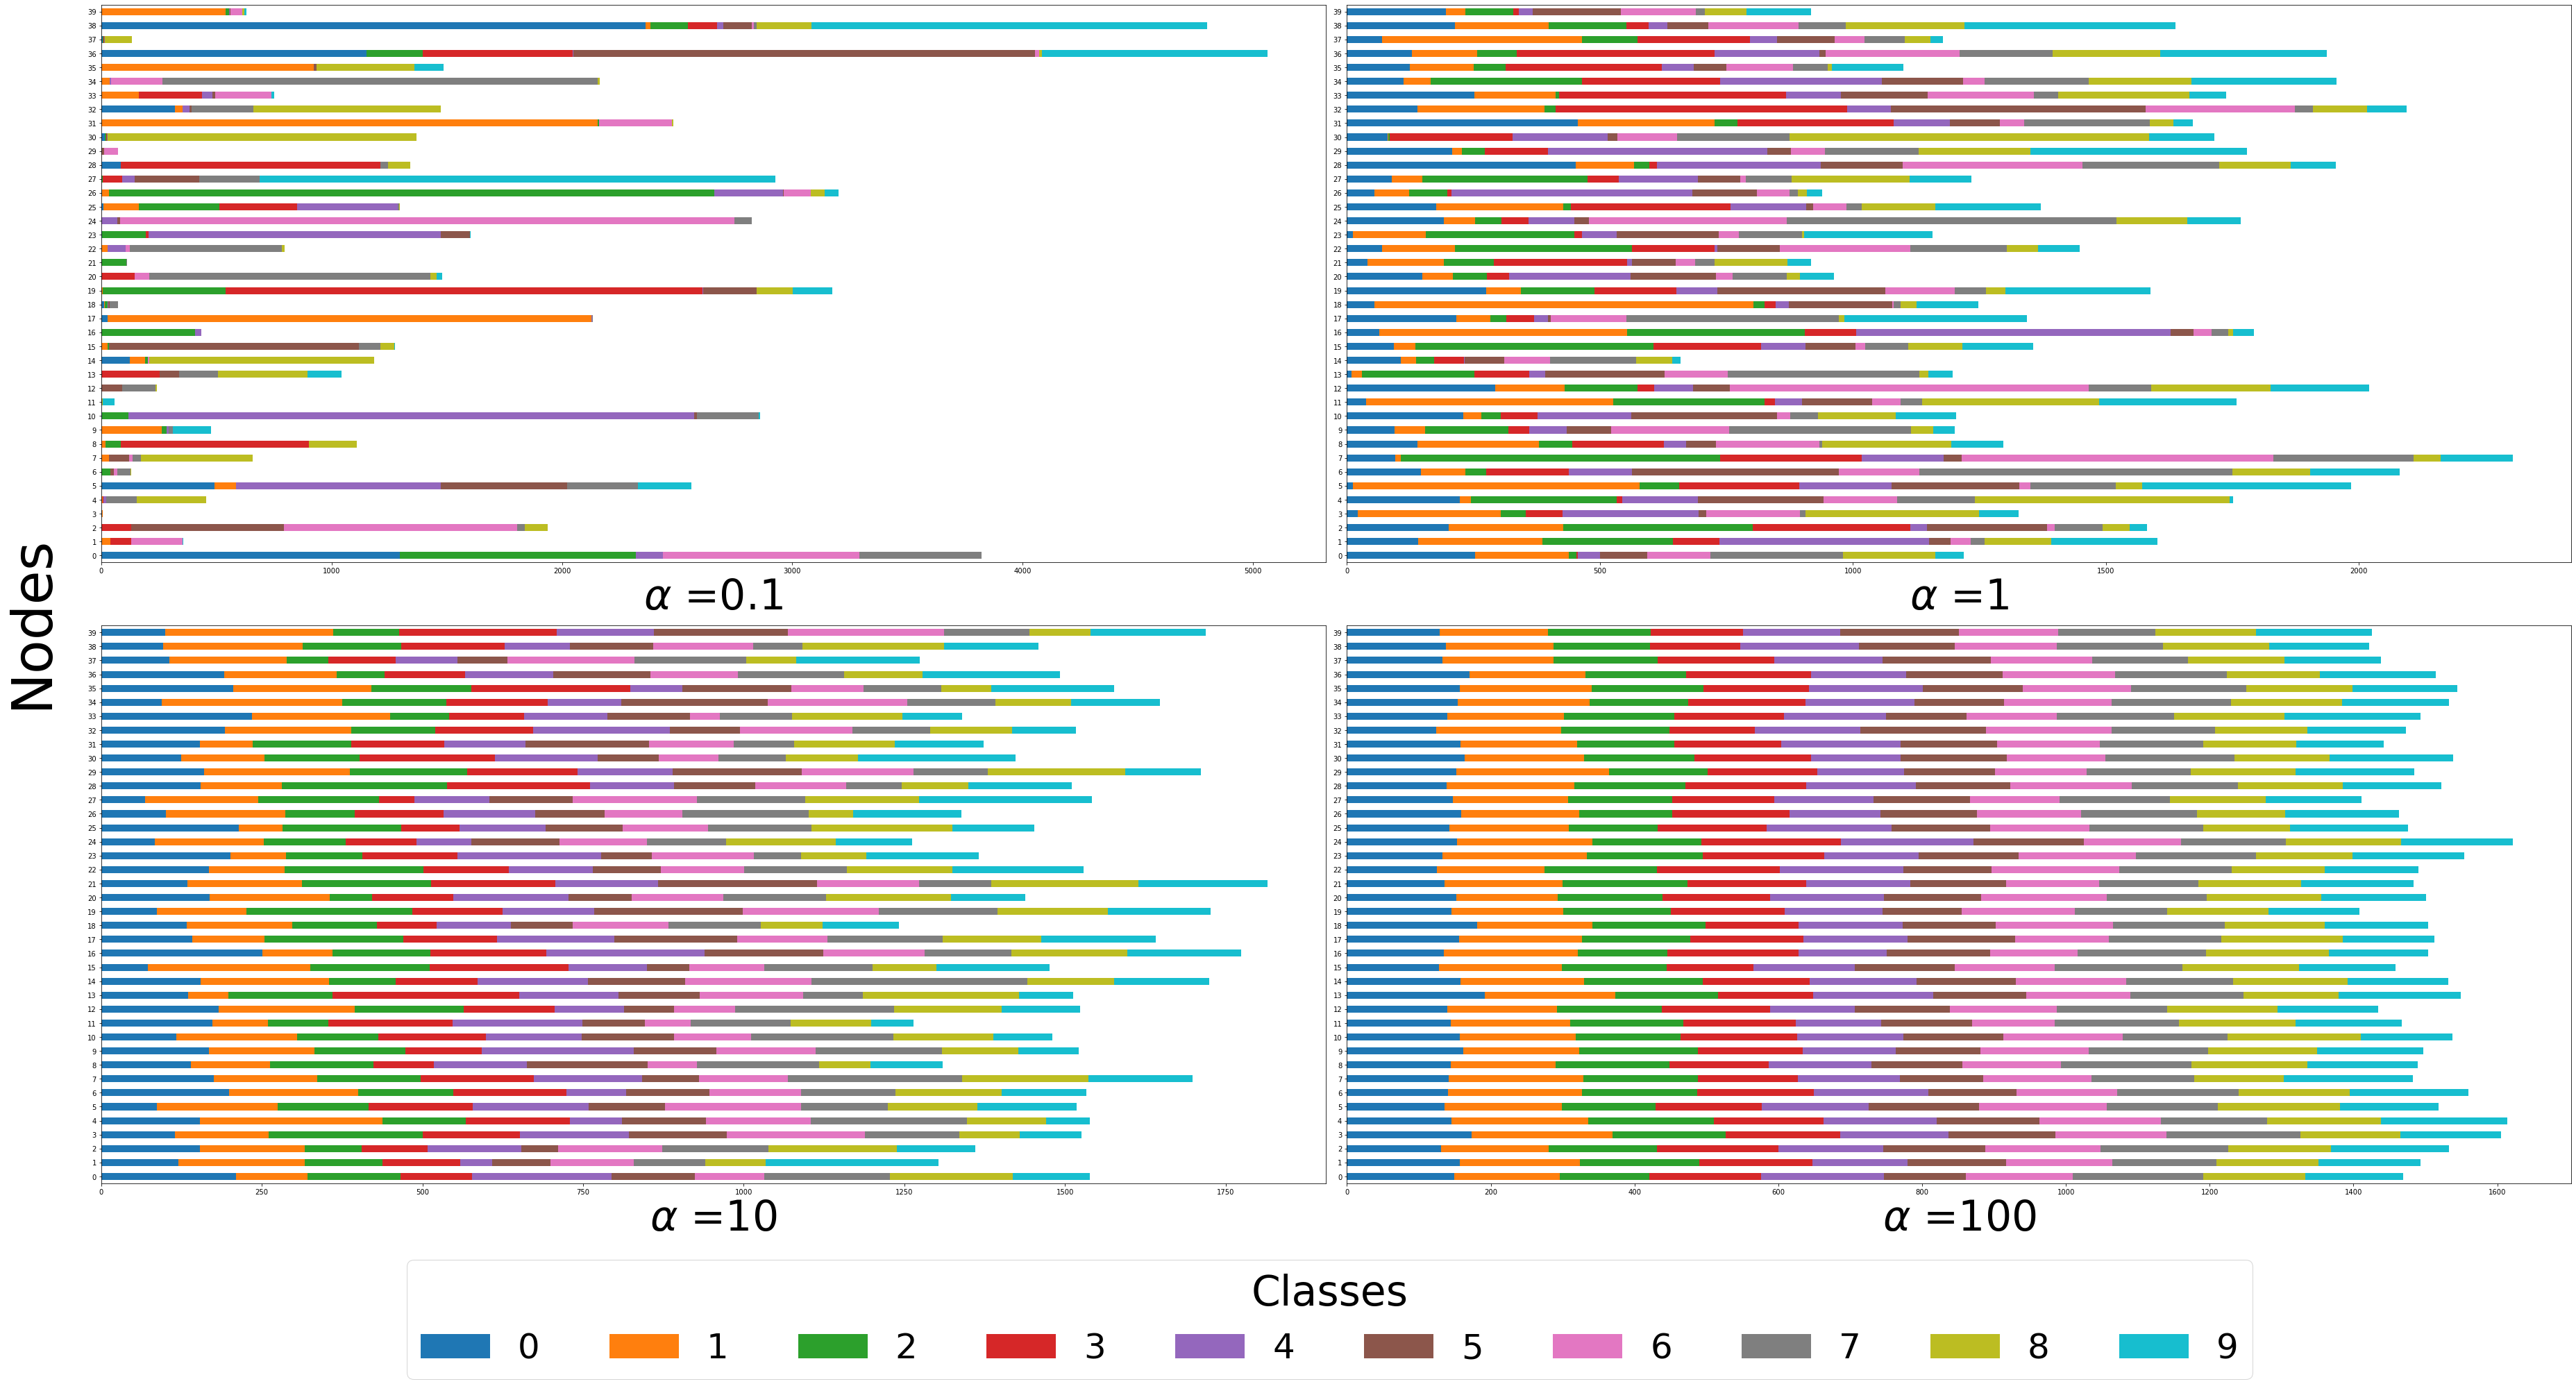

In [14]:
##### num_labels = 10
num_nodes = 40
alpha = [0.1, 1, 10, 100]
labels_list = list(range(num_labels))
# plt.rcParams['text.usetex'] = False
fig, axes = plt.subplots(nrows=2, ncols= int(len(alpha)/2), figsize=(50, 25))
axe = axes.ravel()

for i, alp in enumerate(alpha):
    dd = noniid(traindata, num_labels, num_nodes, alp)
    client_allocs = {i:[] for i in range(num_nodes)}
    for node in range(num_nodes):
        temp  = [traindata.targets[y].item() for y in dd[node]]
        for label in range(num_labels):
            client_allocs[node].append(temp.count(label))
    df = pd.DataFrame(client_allocs)
    df.T.plot.barh(stacked = True, ax = axe[i], legend = False)
    axe[i].set_xlabel(fr'$\alpha$ ={alp}', fontsize = 60)
#     axes[i].text(0.5, -0.1, f'$\alpha = {alp}', size = 36)
fig.text(-0.03, 0.5, 'Nodes', va = 'center', rotation = 'vertical', fontsize = 80)
plt.tight_layout()
legend = fig.legend(labels_list, loc='lower center', ncol = len(labels_list), fontsize = '50', bbox_to_anchor = (0.5, -0.12), title = 'Classes')
plt.setp(legend.get_title(), fontsize = 60)
filename = 'Dirichlet_datadist' + '.jpg'
plt.savefig(filename, dpi =72.72)